# WE10-RNN
## Subash Chandra Biswal (U77884251)

The dataset is for closing price for the stocks of Citigroup Inc. (C) for last 3 years (04/22/2020 - 04/21/2023). The dataset has date, low price, high proce, closing price, volume etc. We are interested in only closing price and we want to predict the future price based on prior 9 days closing price data.

Since our target value is a continous single value we can use ROOT MEAN SQUARE ERROR as the metrics to measure the performance of the models. Since it calculates the distance of predicted value from the actual value. Also the target value is the regression value and RMSE is one of the metrics for regression models validation.

In [1]:
# Common imports
import numpy as np
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import matplotlib.pyplot as plt

np.random.seed(1)
tf.random.set_seed(1)

## Load and split data

The data is stored in a csv file. We will load the data into a pandas dataframe.

In [2]:
data = pd.read_csv("C.csv")

We see that we have 756 observations (closing price) and 7 columns.  

In [3]:
data.shape

(756, 7)

In [4]:
data.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

The closing price column data will be transformed into array of 10 observations.

In [5]:
df = data[['Close']]
df

,Close
0,42.240002
1,42.459999
2,43.099998
3,46.560001
4,47.209999
...,...
751,49.689999
752,50.080002
753,50.400002
754,49.400002


In [6]:
df['Close'].isna().sum()

0

In [79]:
row_count = df.shape[0] # store the number of obersvations (daily closing price readings)
row_count

756

In [80]:
cprice = df.to_numpy() # to make things easier, we create a numpy array from our dataframe of closing prices
cprice.shape

(756, 1)

In [9]:
sequence_length = 10  # here, I create a variable to hold the number of days that will be in a sequence. This makes it easier to change later.

In [10]:
cprice = cprice[row_count % sequence_length: ] # Since our data may not be a multiple of sequence_length, we will ignore 
# the first number of days in order to make the total a number divisible by sequence length
cprice.shape

(750, 1)

In [11]:
cprice = cprice.reshape(row_count // sequence_length, sequence_length) # note that temps are a multiple of sequence length, we can split the data into rows of sequence length.
cprice

array([[48.560001, 45.52    , 45.119999, 43.950001, 42.950001, 44.639999,
        46.32    , 44.07    , 42.349998, 40.599998],
       [42.060001, 41.919998, 45.669998, 44.43    , 45.470001, 45.      ,
        44.099998, 48.169998, 52.259998, 49.16    ],
       [47.91    , 49.450001, 50.84    , 53.34    , 55.650002, 58.860001,
        61.240002, 59.5     , 55.860001, 48.389999],
       [52.25    , 52.98    , 54.450001, 53.      , 53.040001, 52.919998,
        52.060001, 52.950001, 50.810001, 52.68    ],
       [49.580002, 50.290001, 51.099998, 50.349998, 50.549999, 51.970001,
        50.32    , 50.880001, 49.450001, 52.650002],
       [52.200001, 50.150002, 51.84    , 51.459999, 50.220001, 50.139999,
        51.73    , 51.66    , 52.080002, 51.669998],
       [51.290001, 51.27    , 52.52    , 50.869999, 50.009998, 50.389999,
        50.139999, 51.040001, 50.889999, 52.119999],
       [52.860001, 53.759998, 53.349998, 52.889999, 52.93    , 51.419998,
        50.34    , 50.290001, 49.5800

In [12]:
# create our X and y. 
# X will be the 59 days prior...
X = cprice[:, :-1] # all rows, all columns except the last one
# y will be the 60th day (what we are trying to predict)
y = cprice[:, -1] # all rows, only the last column

Finally, we need to split the data into training and test sets. A random split on this data is OK, as each 'game' (observation) is independent of the others. We will use 70% of the data for training and 30% for testing.

In [13]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

## Create dataframe to store results    

We are running 8 models in this notebook. We will store the results in a dataframe for easy comparison.

In [14]:
df_results = pd.DataFrame({'model': [], 'time': [], 'error': [], 'prediction': []})

In [81]:
prior_days = np.array( #this is the data of last 9 days closing price till 21st April 2023. We will use this to predict next closing price
    [
        47.200001,46.919998,47.299999,49.560001,49.689999,50.080002,50.400002,49.400002,49.029999, 
    ]
)

# reshape into the three dimensions for input into model
prior_days = prior_days.reshape(1, 9, 1) # 1 row, 59 time steps (features), and 1 output/prediction)

## Transform data for RNN

RNN requires input of three dimensions:
* The first dimension is the number of observations (games). 
* The second dimension is the number of time steps (minutes). 
* The third dimension is the number of features (1). 
  
Our input variable (X) is a sequence of 36 observations. We will use the `reshape` method to reshape the data into a 3D array. The `reshape` method will return a 3D array with the shape (52, 9, 1) for the training data and (23, 9, 1) for the test data.

In [16]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

print(X_train.shape)
print(X_test.shape)

(52, 9, 1)
(23, 9, 1)


# Simple RNN with one layer

In [17]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Conv1D

n_steps = sequence_length - 1
n_inputs = 1

model = Sequential(
    [
        SimpleRNN(32, input_shape=[n_steps, n_inputs]),
        Dense(1, activation=None)
    ]
)
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 32)                1088      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 1,121
Trainable params: 1,121
Non-trainable params: 0
_________________________________________________________________


In [82]:
# If the traget value is a continous value, the metrics we can use is root mean square to calculate the distance from the actual value.
model.compile(
    loss="mean_squared_error", 
    optimizer=tf.keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [19]:
from tensorflow.keras.callbacks import EarlyStopping

import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=5, verbose=0, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=2000,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop]
)

end_time = time.time()

Epoch 1/2000
2/2 [==============================] - 2s 564ms/step - loss: 3381.0510 - root_mean_squared_error: 58.1468 - val_loss: 3567.8452 - val_root_mean_squared_error: 59.7314
Epoch 2/2000
2/2 [==============================] - 0s 46ms/step - loss: 3367.7986 - root_mean_squared_error: 58.0327 - val_loss: 3557.3369 - val_root_mean_squared_error: 59.6434
Epoch 3/2000
2/2 [==============================] - 0s 69ms/step - loss: 3357.4519 - root_mean_squared_error: 57.9435 - val_loss: 3547.2092 - val_root_mean_squared_error: 59.5585
Epoch 4/2000
2/2 [==============================] - 0s 44ms/step - loss: 3347.4702 - root_mean_squared_error: 57.8573 - val_loss: 3537.2007 - val_root_mean_squared_error: 59.4744
Epoch 5/2000
2/2 [==============================] - 0s 45ms/step - loss: 3337.5793 - root_mean_squared_error: 57.7718 - val_loss: 3527.2126 - val_root_mean_squared_error: 59.3903
Epoch 6/2000
2/2 [==============================] - 0s 46ms/step - loss: 3327.6990 - root_mean_squared_e

### How to interpret the output shape.

* First layer:
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network.
  * There are 32 RNN units and each produces one output. Therefore, 32 is the output shape.
* In the second layer, there is one unit and it produces one output. Therefore, 1 * 1 = 1

### Calculate the number of paramaters for the model

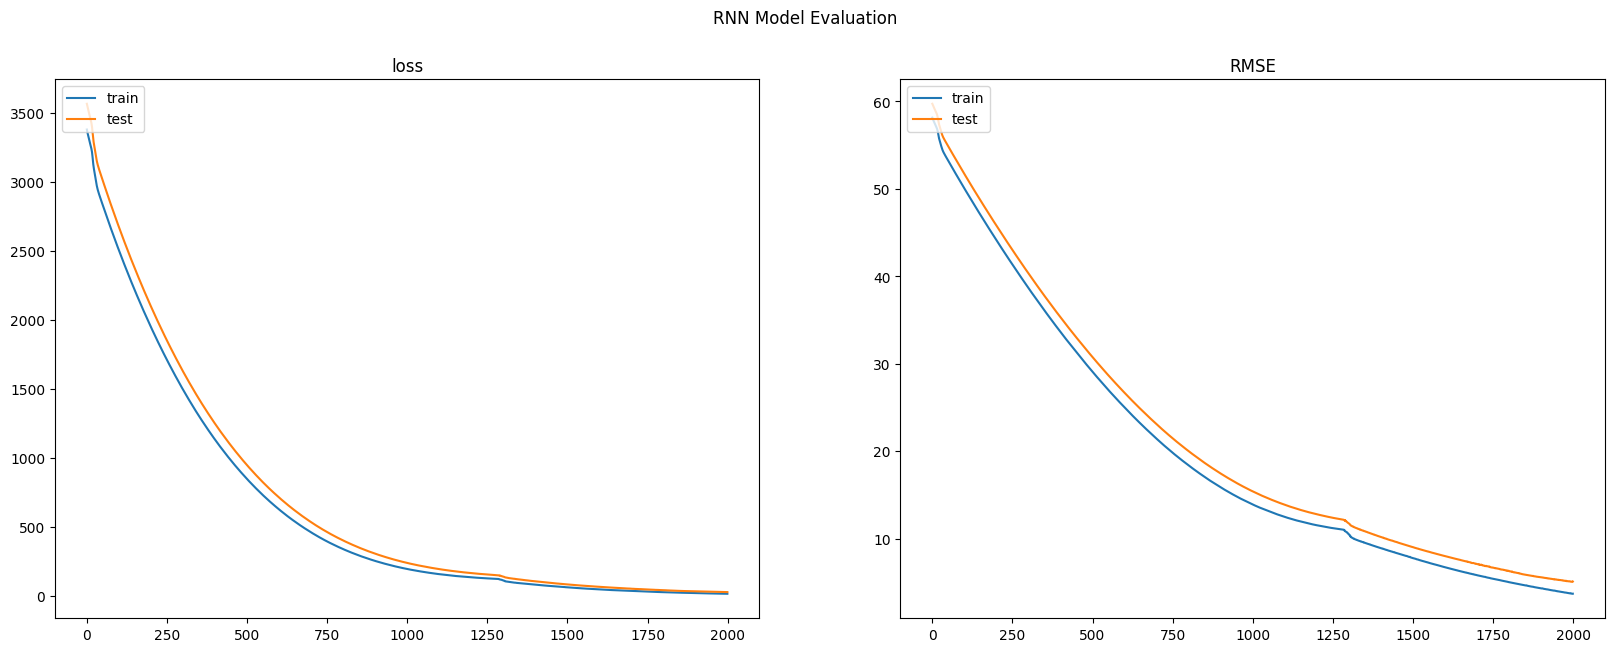

In [20]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [21]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

me=mean_squared_error(y_test, y_pred)**0.5
me

1/1 [==============================] - 0s 353ms/step


5.089603646901744

In [22]:
tomorrows_cprice = model.predict(prior_days)[0][0]

1/1 [==============================] - 0s 33ms/step


In [23]:
tomorrows_cprice

50.312363

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['RNN'], 
        'time': [end_time - start_time],
        'error': [me],
        'prediction': [tomorrows_cprice]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# Deep RNN

**Be careful: when stacking RNN layers, you have to set "return_sequences" to True. This enables the layer to send a "sequence" of values to the next layer -- jut like how it uses a sequence of values for training.**

**Since the last layer is DENSE, it can't take sequence data. Therefore, you CANNOT return sequences from the previous layer. So, remove** `return_sequences` **from previous layer.**

In [25]:
n_steps = sequence_length - 1
n_inputs = 1

model = keras.models.Sequential(
    [
        keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[n_steps, n_inputs]),
        keras.layers.SimpleRNN(16, return_sequences=True),
        keras.layers.SimpleRNN(32, return_sequences=False), 
        keras.layers.Dense(1, activation=None)
    ]
)

In [26]:
model.compile(
    loss="mean_squared_error", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_1 (SimpleRNN)    (None, 9, 32)             1088      
                                                                 
 simple_rnn_2 (SimpleRNN)    (None, 9, 16)             784       
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 32)                1568      
                                                                 
 dense_1 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,473
Trainable params: 3,473
Non-trainable params: 0
_________________________________________________________________


### How to  intepret the output shape?

* First layer:
  * None is a wild-card representing the number of observations - this will be the number of observations in a batch that is fed into the network.
  * There are 9 features (which are the 'time steps' of values in the sequence), and there are 32 RNN units.
    * (batch size, time steps, features) = (None, 9, 32)
* etc. (see previous models where I elaborate on the output shape - writing this is getting repetitive)

### Calculate the number of paramaters for the model

In [27]:
p = 1 # number of parameters per unit (for RNN one remember gate)
b = 1 # number of biases per unit, for RNN this is 1 (for GRU this is 3, and LSTM this is 4)

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# For second layer....

h = 16 # number of units in the layer
i = 32  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("Second layer params = ", params)

##################################
# For third layer....

h = 32 # number of units in the layer
i = 16  # number of inputs (previous layer has 16 inutes, so we have 16 inputs)

params = p*(h**2+i*h+b*h)
print("Third layer params = ", params)


##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  1088
Second layer params =  784
Third layer params =  1568
Last layer params =  33


In [28]:
import time
from tensorflow.keras.callbacks import EarlyStopping
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta=0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=2000,
    validation_data = (X_test, y_test), 
    callbacks=[early_stop]
)  

end_time = time.time()

Epoch 1/2000
2/2 [==============================] - 7s 916ms/step - loss: 3370.0408 - root_mean_squared_error: 58.0521 - val_loss: 3512.3767 - val_root_mean_squared_error: 59.2653
Epoch 2/2000
2/2 [==============================] - 0s 50ms/step - loss: 3303.5703 - root_mean_squared_error: 57.4767 - val_loss: 3448.3257 - val_root_mean_squared_error: 58.7224
Epoch 3/2000
2/2 [==============================] - 0s 45ms/step - loss: 3239.8423 - root_mean_squared_error: 56.9196 - val_loss: 3382.8118 - val_root_mean_squared_error: 58.1619
Epoch 4/2000
2/2 [==============================] - 0s 44ms/step - loss: 3177.6306 - root_mean_squared_error: 56.3705 - val_loss: 3324.1882 - val_root_mean_squared_error: 57.6558
Epoch 5/2000
2/2 [==============================] - 0s 47ms/step - loss: 3122.6978 - root_mean_squared_error: 55.8811 - val_loss: 3280.4729 - val_root_mean_squared_error: 57.2754
Epoch 6/2000
2/2 [==============================] - 0s 49ms/step - loss: 3082.4893 - root_mean_squared_e

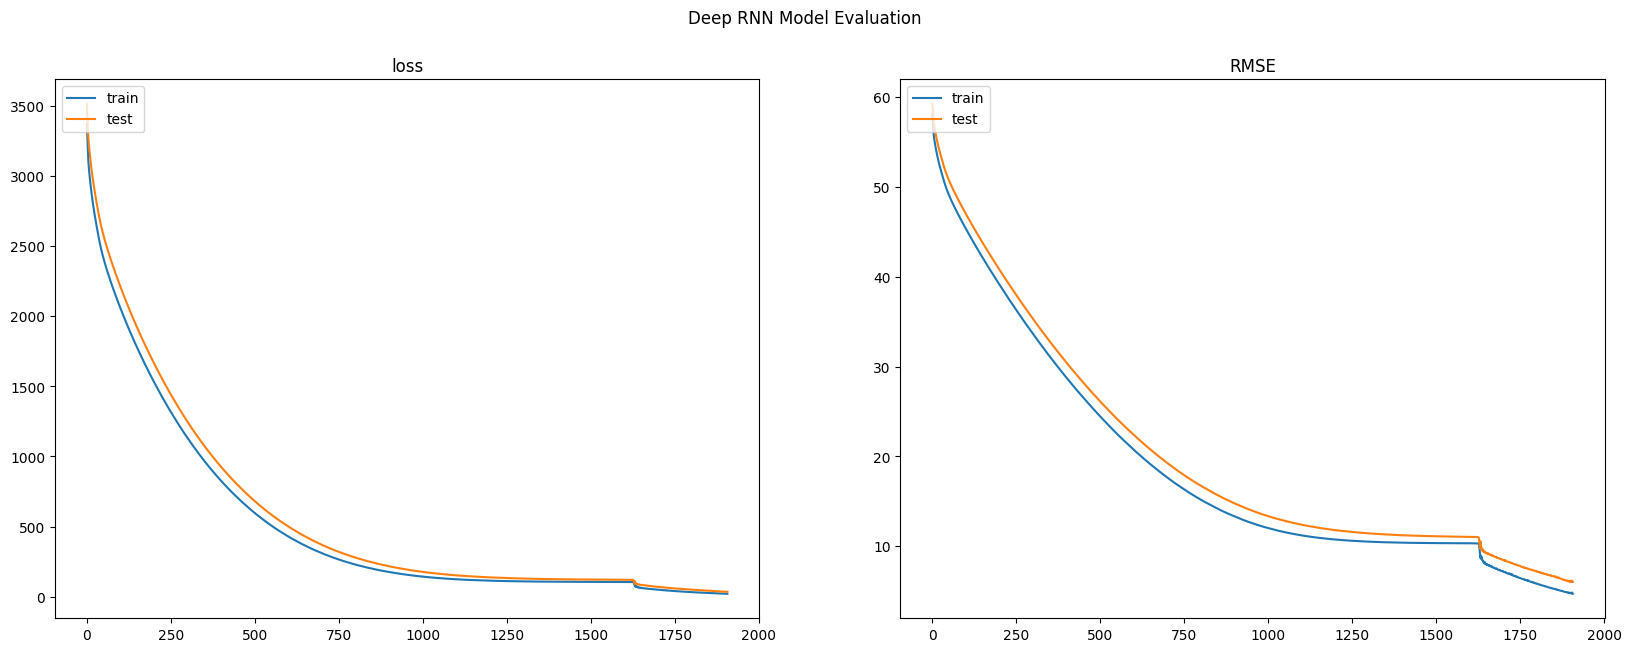

In [29]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Deep RNN Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [30]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

me=mean_squared_error(y_test, y_pred)**0.5
me

1/1 [==============================] - 1s 723ms/step


6.027035069981759

In [31]:
tomorrows_cprice = model.predict(prior_days)[0][0]

1/1 [==============================] - 0s 35ms/step


In [32]:
tomorrows_cprice

50.45209

In [33]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Deep RNN'], 
        'time': [end_time - start_time],
        'error': [me],
        'prediction': [tomorrows_cprice]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# LSTM with one layer

In [34]:
n_steps = sequence_length - 1
n_inputs = 1

model = keras.models.Sequential(
    [
        keras.layers.LSTM(32, input_shape=[n_steps, n_inputs]),
        keras.layers.Dense(1, activation=None)
    ]
)

In [35]:
model.compile(
    loss="mean_squared_error", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 32)                4352      
                                                                 
 dense_2 (Dense)             (None, 1)                 33        
                                                                 
Total params: 4,385
Trainable params: 4,385
Non-trainable params: 0
_________________________________________________________________


### Calculate the number of paramaters for the model

In [36]:
p = 4 # number of parameters per unit (for LSTM: 1 forget gate, 2 input gates, and 1 output gate)
b = 1 # number of biases per unit, for LSTM this is 1

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  4352
Last layer params =  33


In [37]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=2000,
    validation_data=(X_test, y_test),
    callbacks=[early_stop]
) 

end_time = time.time()

Epoch 1/2000
2/2 [==============================] - 6s 1s/step - loss: 3214.6643 - root_mean_squared_error: 56.6980 - val_loss: 3405.5640 - val_root_mean_squared_error: 58.3572
Epoch 2/2000
2/2 [==============================] - 0s 49ms/step - loss: 3208.2893 - root_mean_squared_error: 56.6418 - val_loss: 3395.2725 - val_root_mean_squared_error: 58.2690
Epoch 3/2000
2/2 [==============================] - 0s 44ms/step - loss: 3198.2500 - root_mean_squared_error: 56.5531 - val_loss: 3387.4731 - val_root_mean_squared_error: 58.2020
Epoch 4/2000
2/2 [==============================] - 0s 44ms/step - loss: 3191.0796 - root_mean_squared_error: 56.4896 - val_loss: 3381.6431 - val_root_mean_squared_error: 58.1519
Epoch 5/2000
2/2 [==============================] - 0s 43ms/step - loss: 3185.2896 - root_mean_squared_error: 56.4384 - val_loss: 3375.5417 - val_root_mean_squared_error: 58.0994
Epoch 6/2000
2/2 [==============================] - 0s 40ms/step - loss: 3179.1636 - root_mean_squared_erro

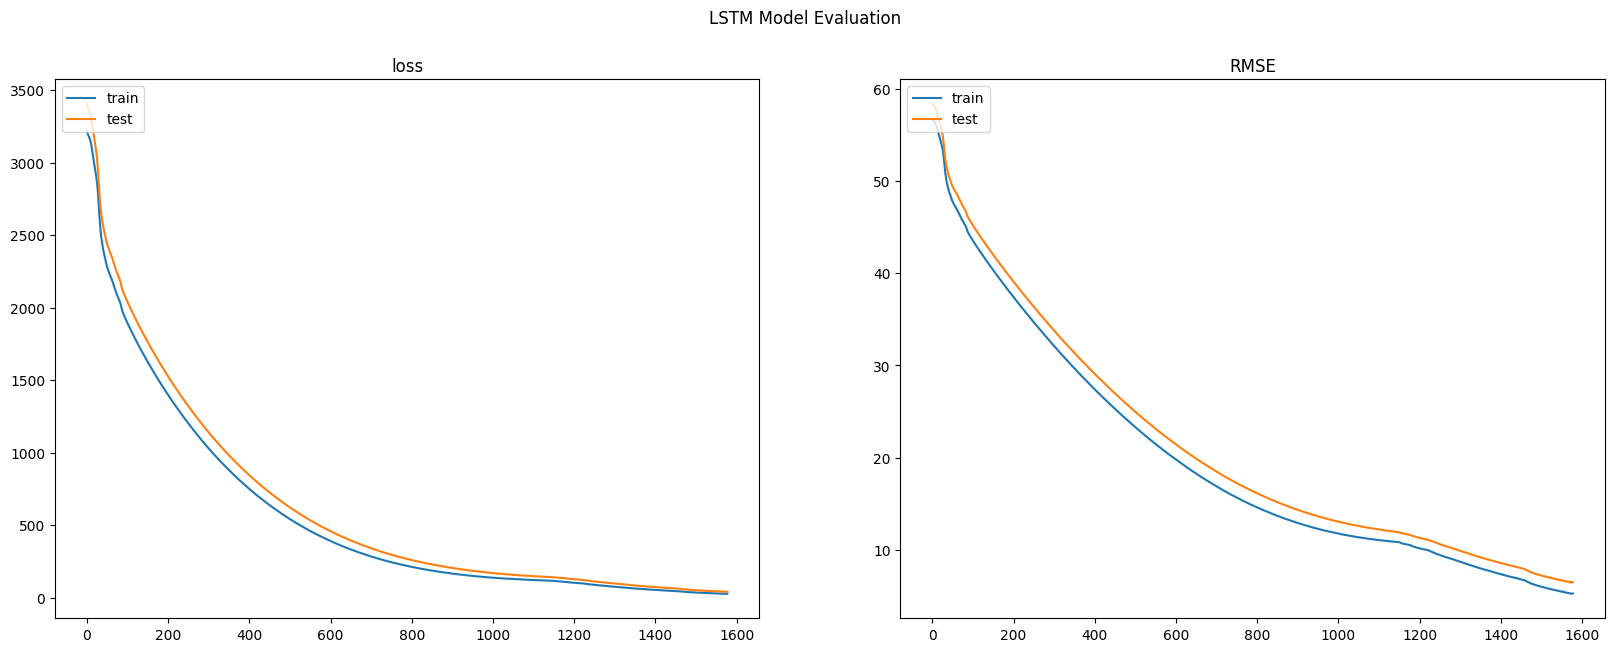

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('LSTM Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [39]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

me=mean_squared_error(y_test, y_pred)**0.5
me

1/1 [==============================] - 1s 813ms/step


6.481349644277365

In [40]:
tomorrows_cprice = model.predict(prior_days)[0][0]

1/1 [==============================] - 0s 35ms/step


In [41]:
tomorrows_cprice

49.24778

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['LSTM'], 
        'time': [end_time - start_time],
        'error': [me],
        'prediction': [tomorrows_cprice]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# LSTM with more layers

In [43]:
n_steps = sequence_length - 1
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.LSTM(32, return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation=None)
])

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model.compile(
    loss="mean_squared_error", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 9, 32)             4352      
                                                                 
 lstm_2 (LSTM)               (None, 9, 32)             8320      
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_3 (Dense)             (None, 1)                 33        
                                                                 
Total params: 21,025
Trainable params: 21,025
Non-trainable params: 0
_________________________________________________________________


### Calculate the number of paramaters for the model

In [45]:
# Everything is the same as calculating the RNN, except for p
p = 4 # number of parameters per unit (for LSTM - 1 forget gate, 2 input gates, and 1 output gate)
b = 1 # number of biases per unit, for LSTM this is 1

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# for the second layer

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 incoming inputs)

params = p*(h**2+i*h+b*h)
print("Second layer params = ", params)

##################################
# for the third layer

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 incoming inputs)

params = p*(h**2+i*h+b*h)
print("Third layer params = ", params)


##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  4352
Second layer params =  8320
Third layer params =  8320
Last layer params =  33


In [46]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=2000,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop] # we defined this early_stop callback function earlier
)

end_time = time.time()

Epoch 1/2000
2/2 [==============================] - 14s 3s/step - loss: 3302.4536 - root_mean_squared_error: 57.4670 - val_loss: 3490.6738 - val_root_mean_squared_error: 59.0819
Epoch 2/2000
2/2 [==============================] - 0s 47ms/step - loss: 3290.9045 - root_mean_squared_error: 57.3664 - val_loss: 3481.1609 - val_root_mean_squared_error: 59.0014
Epoch 3/2000
2/2 [==============================] - 0s 47ms/step - loss: 3281.6182 - root_mean_squared_error: 57.2854 - val_loss: 3471.2915 - val_root_mean_squared_error: 58.9177
Epoch 4/2000
2/2 [==============================] - 0s 50ms/step - loss: 3271.8330 - root_mean_squared_error: 57.1999 - val_loss: 3460.1111 - val_root_mean_squared_error: 58.8227
Epoch 5/2000
2/2 [==============================] - 0s 51ms/step - loss: 3260.5889 - root_mean_squared_error: 57.1016 - val_loss: 3446.2810 - val_root_mean_squared_error: 58.7050
Epoch 6/2000
2/2 [==============================] - 0s 50ms/step - loss: 3246.3936 - root_mean_squared_err

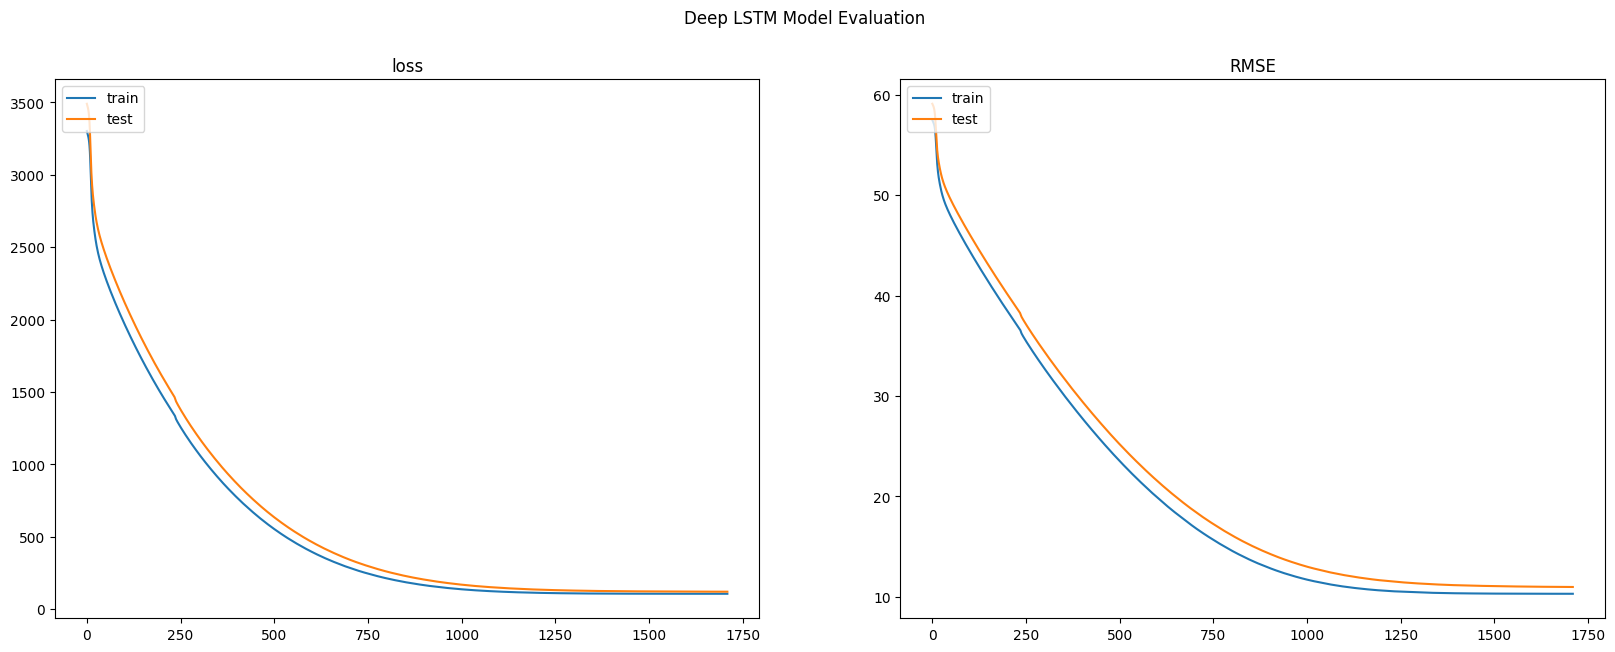

In [47]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Deep LSTM Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [48]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

me=mean_squared_error(y_test, y_pred)**0.5
me

1/1 [==============================] - 2s 2s/step


10.994432444388561

In [49]:
tomorrows_cprice = model.predict(prior_days)[0][0]

1/1 [==============================] - 0s 29ms/step


In [50]:
tomorrows_cprice

56.193756

In [51]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Deep LSTM'], 
        'time': [end_time - start_time],
        'error': [me],
        'prediction': [tomorrows_cprice]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# GRU with one layer

In [52]:
n_steps = sequence_length - 1
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.GRU(32, input_shape=[n_steps, n_inputs]),
    keras.layers.Dense(1, activation=None)
])

In [53]:
model.compile(
    loss="mean_squared_error", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 32)                3360      
                                                                 
 dense_4 (Dense)             (None, 1)                 33        
                                                                 
Total params: 3,393
Trainable params: 3,393
Non-trainable params: 0
_________________________________________________________________


### Calculate the number of paramaters for the model

In [54]:
# Everything is the same as calculating the RNN or LSTM parameters, except for p
p = 3 # number of parameters per unit (for GRU - 1 forget gate, 1 input gates, and 1 output gate)
b = 2 # number of biases per unit, for GRU this is 2

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  3360
Last layer params =  33


In [55]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=2000,
    validation_data=(X_test, y_test),
    callbacks=[early_stop] # we defined this early_stop callback function earlier
)

end_time = time.time()

Epoch 1/2000
2/2 [==============================] - 6s 925ms/step - loss: 3368.2488 - root_mean_squared_error: 58.0366 - val_loss: 3558.9082 - val_root_mean_squared_error: 59.6566
Epoch 2/2000
2/2 [==============================] - 0s 57ms/step - loss: 3358.5718 - root_mean_squared_error: 57.9532 - val_loss: 3550.3367 - val_root_mean_squared_error: 59.5847
Epoch 3/2000
2/2 [==============================] - 0s 45ms/step - loss: 3350.0986 - root_mean_squared_error: 57.8800 - val_loss: 3541.2688 - val_root_mean_squared_error: 59.5086
Epoch 4/2000
2/2 [==============================] - 0s 58ms/step - loss: 3341.1040 - root_mean_squared_error: 57.8023 - val_loss: 3531.5652 - val_root_mean_squared_error: 59.4270
Epoch 5/2000
2/2 [==============================] - 0s 53ms/step - loss: 3331.5132 - root_mean_squared_error: 57.7193 - val_loss: 3521.3003 - val_root_mean_squared_error: 59.3405
Epoch 6/2000
2/2 [==============================] - 0s 46ms/step - loss: 3321.3359 - root_mean_squared_e

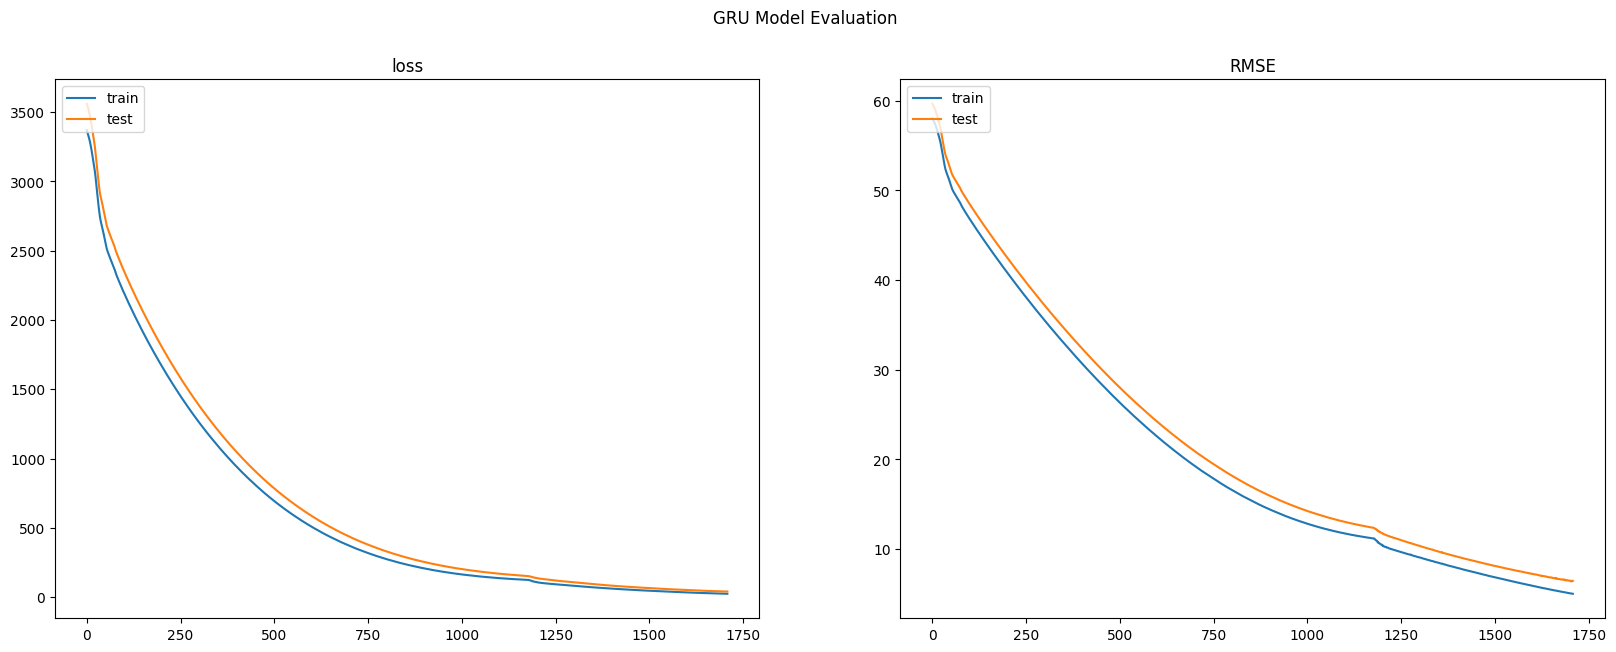

In [56]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('GRU Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [57]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

me=mean_squared_error(y_test, y_pred)**0.5
me

1/1 [==============================] - 2s 2s/step


6.453638780317888

In [58]:
tomorrows_cprice = model.predict(prior_days)[0][0]

1/1 [==============================] - 0s 32ms/step


In [59]:
tomorrows_cprice

50.10786

In [60]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['GRU'], 
        'time': [end_time - start_time],
        'error': [me],
        'prediction': [tomorrows_cprice]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# GRU with more layers

In [61]:
n_steps = sequence_length - 1
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.GRU(32, return_sequences=True, input_shape=[n_steps, n_inputs]),
    keras.layers.GRU(32, return_sequences=True),
    keras.layers.GRU(32),
    keras.layers.Dense(1, activation=None)
])

In [62]:
model.compile(
    loss="mean_squared_error", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.001), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_1 (GRU)                 (None, 9, 32)             3360      
                                                                 
 gru_2 (GRU)                 (None, 9, 32)             6336      
                                                                 
 gru_3 (GRU)                 (None, 32)                6336      
                                                                 
 dense_5 (Dense)             (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


### Calculate the number of paramaters for the model

In [63]:
# Everything is the same as calculating the RNN or LSTM parameters, except for p
p = 3 # number of parameters per unit (for GRU - 1 forget gate, 1 input gates, and 1 output gate)
b = 2 # number of biases per unit, for GRU this is 2

##################################
# For first layer....

h = 32 # number of units in the layer
i = 1  # number of inputs (if we are predicting a stock price based on previous stock prices, input = 1. 
# NOTE: If we are predicting a stock price based on previous stock prices and the price of oil, input = 2), etc.

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# For second layer....

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 inputs)

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)

##################################
# For third layer....

h = 32 # number of units in the layer
i = 32  # number of inputs (previous layer has 32 units, therefore 32 inputs)

params = p*(h**2+i*h+b*h)
print("First layer params = ", params)


##################################
# for the last layer

# This is simply 32 outputs coming from the previous later plus 1 bias term
print("Last layer params = ", 32+1)

First layer params =  3360
First layer params =  6336
First layer params =  6336
Last layer params =  33


In [64]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=2000,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop] 
)

end_time = time.time()

Epoch 1/2000
2/2 [==============================] - 16s 3s/step - loss: 3286.5667 - root_mean_squared_error: 57.3286 - val_loss: 3451.5261 - val_root_mean_squared_error: 58.7497
Epoch 2/2000
2/2 [==============================] - 0s 56ms/step - loss: 3248.2112 - root_mean_squared_error: 56.9931 - val_loss: 3415.6860 - val_root_mean_squared_error: 58.4439
Epoch 3/2000
2/2 [==============================] - 0s 117ms/step - loss: 3212.5823 - root_mean_squared_error: 56.6796 - val_loss: 3375.7625 - val_root_mean_squared_error: 58.1013
Epoch 4/2000
2/2 [==============================] - 0s 65ms/step - loss: 3172.9944 - root_mean_squared_error: 56.3293 - val_loss: 3331.9229 - val_root_mean_squared_error: 57.7228
Epoch 5/2000
2/2 [==============================] - 0s 58ms/step - loss: 3130.0637 - root_mean_squared_error: 55.9470 - val_loss: 3285.9373 - val_root_mean_squared_error: 57.3231
Epoch 6/2000
2/2 [==============================] - 0s 63ms/step - loss: 3085.2671 - root_mean_squared_er

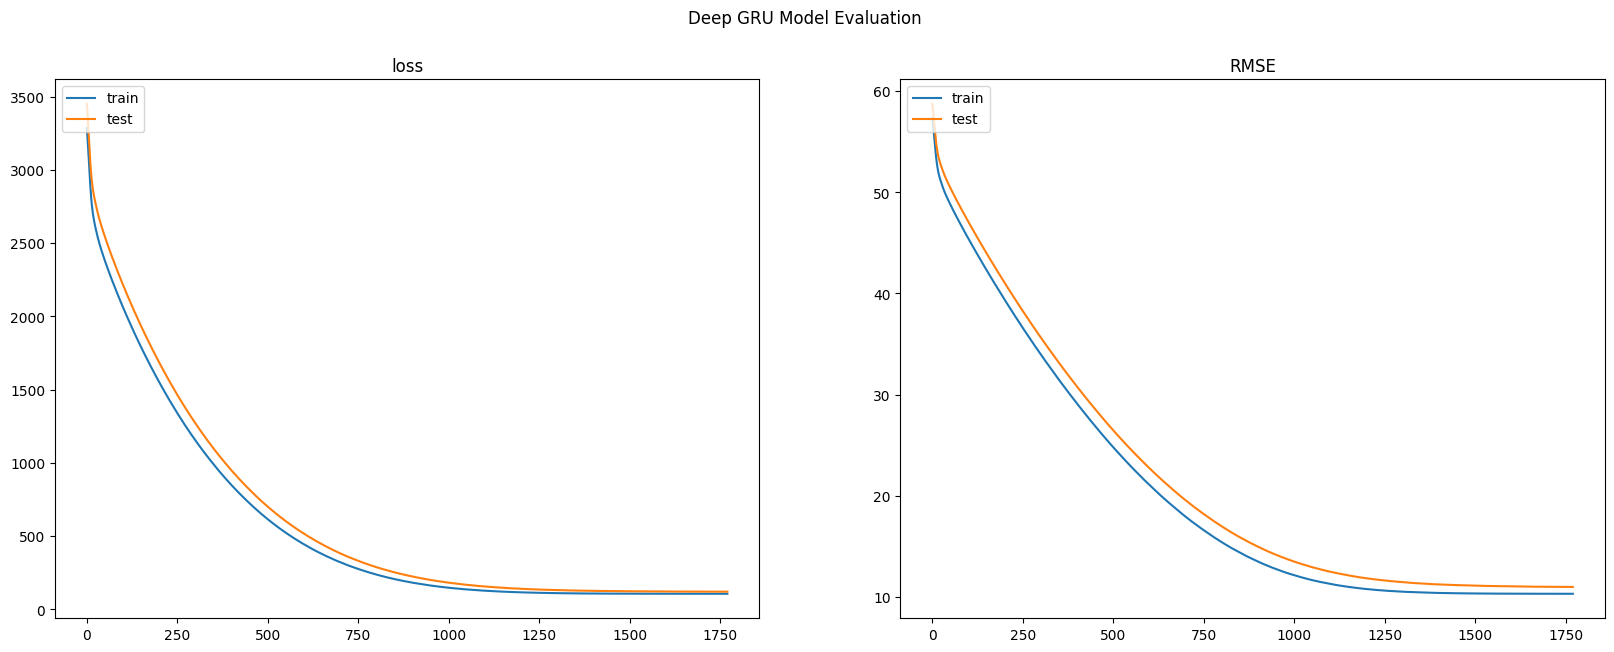

In [65]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Deep GRU Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [66]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

me=mean_squared_error(y_test, y_pred)**0.5
me

1/1 [==============================] - 3s 3s/step


10.993220320199088

In [67]:
tomorrows_cprice = model.predict(prior_days)[0][0]

1/1 [==============================] - 0s 31ms/step


In [68]:
tomorrows_cprice

56.20131

In [69]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Deep GRU'], 
        'time': [end_time - start_time],
        'error': [me],
        'prediction': [tomorrows_cprice]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

# Conv1D

In [70]:
n_steps = sequence_length - 1
n_inputs = 1

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=10, kernel_size=3, strides=1, padding="valid", input_shape=[n_steps, n_inputs]),
    keras.layers.Conv1D(filters=20, kernel_size=3, strides=1, padding="valid"),
    keras.layers.LSTM(32, return_sequences=True),
    keras.layers.LSTM(32),
    keras.layers.Dense(1, activation=None)
])

model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 7, 10)             40        
                                                                 
 conv1d_1 (Conv1D)           (None, 5, 20)             620       
                                                                 
 lstm_4 (LSTM)               (None, 5, 32)             6784      
                                                                 
 lstm_5 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 1)                 33        
                                                                 
Total params: 15,797
Trainable params: 15,797
Non-trainable params: 0
_________________________________________________________________


In [71]:
model.compile(
    loss="mean_squared_error", 
    optimizer=keras.optimizers.Nadam(learning_rate=0.010), 
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

In [72]:
import time
start_time = time.time()

early_stop = EarlyStopping(monitor='val_root_mean_squared_error', min_delta = 0.0, patience=5, verbose=1, mode='min')

history = model.fit(
    X_train, 
    y_train, 
    epochs=2000,
    validation_data=(X_test, y_test), 
    callbacks=[early_stop] 
)

end_time = time.time()

Epoch 1/2000
2/2 [==============================] - 11s 2s/step - loss: 3229.9075 - root_mean_squared_error: 56.8323 - val_loss: 3244.0190 - val_root_mean_squared_error: 56.9563
Epoch 2/2000
2/2 [==============================] - 0s 135ms/step - loss: 3001.1443 - root_mean_squared_error: 54.7827 - val_loss: 2962.3132 - val_root_mean_squared_error: 54.4271
Epoch 3/2000
2/2 [==============================] - 0s 174ms/step - loss: 2738.6523 - root_mean_squared_error: 52.3321 - val_loss: 2767.4451 - val_root_mean_squared_error: 52.6065
Epoch 4/2000
2/2 [==============================] - 0s 169ms/step - loss: 2564.1799 - root_mean_squared_error: 50.6377 - val_loss: 2636.6313 - val_root_mean_squared_error: 51.3481
Epoch 5/2000
2/2 [==============================] - 0s 160ms/step - loss: 2446.2178 - root_mean_squared_error: 49.4593 - val_loss: 2546.5200 - val_root_mean_squared_error: 50.4631
Epoch 6/2000
2/2 [==============================] - 0s 159ms/step - loss: 2362.9221 - root_mean_square

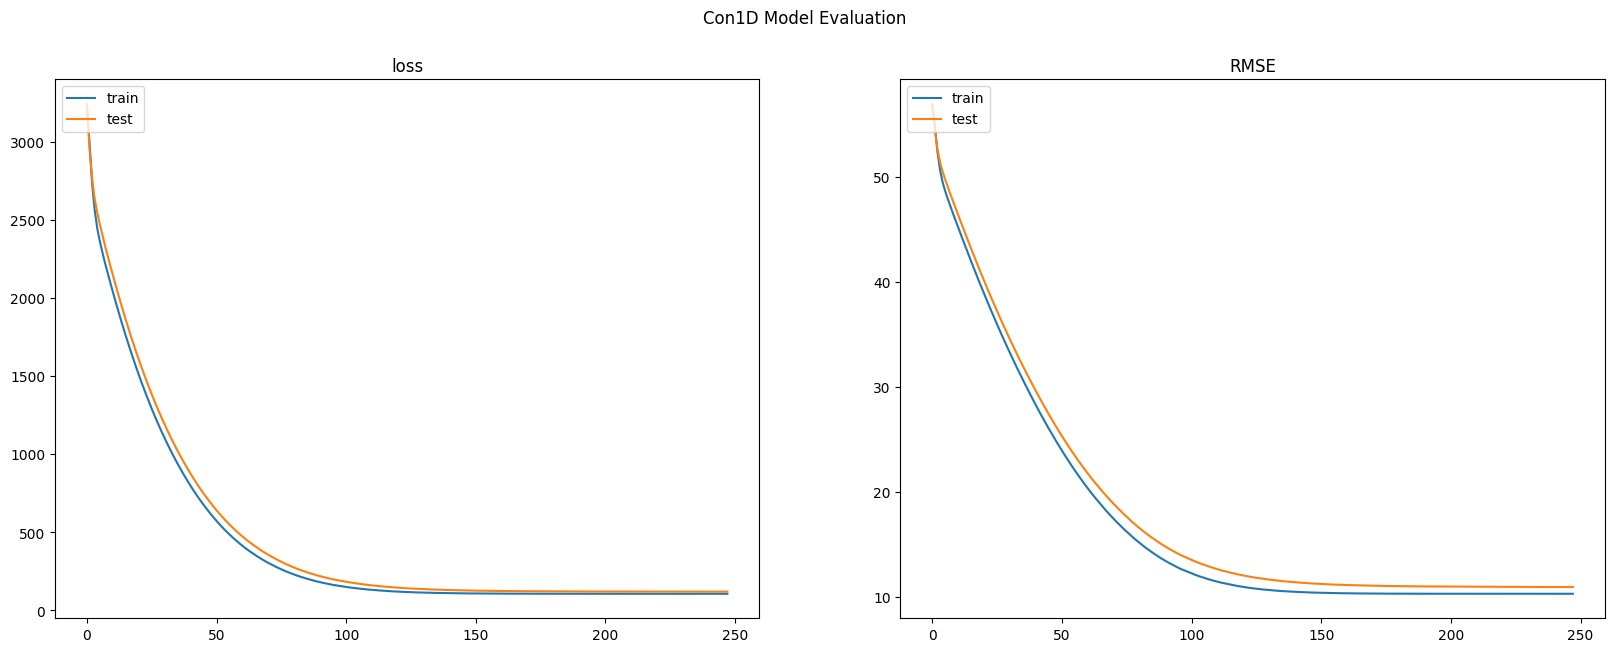

In [73]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7))
fig.suptitle('Con1D Model Evaluation')

ax1.set_title('loss')
#ax1.set_ylim(0, 100)
ax1.plot(history.history['loss'])
ax1.plot(history.history['val_loss'])
ax1.legend(['train', 'test'], loc='upper left')

ax2.set_title('RMSE')
#ax2.set_ylim(0, 1)
ax2.plot(history.history['root_mean_squared_error'])
ax2.plot(history.history['val_root_mean_squared_error'])
ax2.legend(['train', 'test'], loc='upper left')

In [74]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)  # these predictions are probabilities (0-1) taken from the sigmoid function

me=mean_squared_error(y_test, y_pred)**0.5
me

1/1 [==============================] - 2s 2s/step


10.962890842825912

In [75]:
tomorrows_cprice = model.predict(prior_days)[0][0]

1/1 [==============================] - 0s 30ms/step


In [76]:
tomorrows_cprice

56.401245

In [77]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

df_result = pd.DataFrame(
    {
        'model': ['Con1D Deep LSTM'], 
        'time': [end_time - start_time],
        'error': [me],
        'prediction': [tomorrows_cprice]
    }
)

df_results = pd.concat([df_results, df_result], ignore_index=True, axis=0)

## Summary of results

In [78]:
df_results.sort_values(by=['error','time'], ascending=True)

,model,time,error,prediction
0,RNN,158.147619,5.089604,50.312363
1,Deep RNN,204.277828,6.027035,50.452091
4,GRU,134.788048,6.453639,50.107861
2,LSTM,131.388273,6.481350,49.247780
6,Con1D Deep LSTM,87.561269,10.962891,56.401245
5,Deep GRU,215.703340,10.993220,56.201309
3,Deep LSTM,176.089350,10.994432,56.193756


# Analysis of Models

Out of the 7 models we used to predict the next closing price based on the prior 9 days closing price, the Deep GRU model is the most time consuming model (216 secs) and the con1D is the least time consuming (86 secs) model. The Deep LSTM is the most error prone (RMSE=11) model and the RNN is the least error prone (RMSE=5) model. Based on the time and error the best model would be GRU with time (135 secs) and error (RMSE=6.5) which predicts next closing price to be 50.11 which is not very different than the RNN model (50.31) which has least error.